In [1]:
#Imported python libraries
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import Embedding,LSTM,Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from nltk.stem.porter import PorterStemmer
from tqdm import tqdm
import re
import numpy as np
import missingno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix
from kerastuner.tuners import RandomSearch
import keras
from keras.optimizers import Adam

In [2]:
tf.__version__ #Checked the version of tensorflow

'2.4.1'

In [84]:
#https://www.kaggle.com/c/fake-news/data  #Kaggle dataset link

In [82]:
df_train=pd.read_csv('fake-news/train.csv')
df_test=pd.read_csv('fake-news/test.csv')    #Data Downloaded from kaggle, training and testing data

In [4]:
df_train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


<AxesSubplot:>

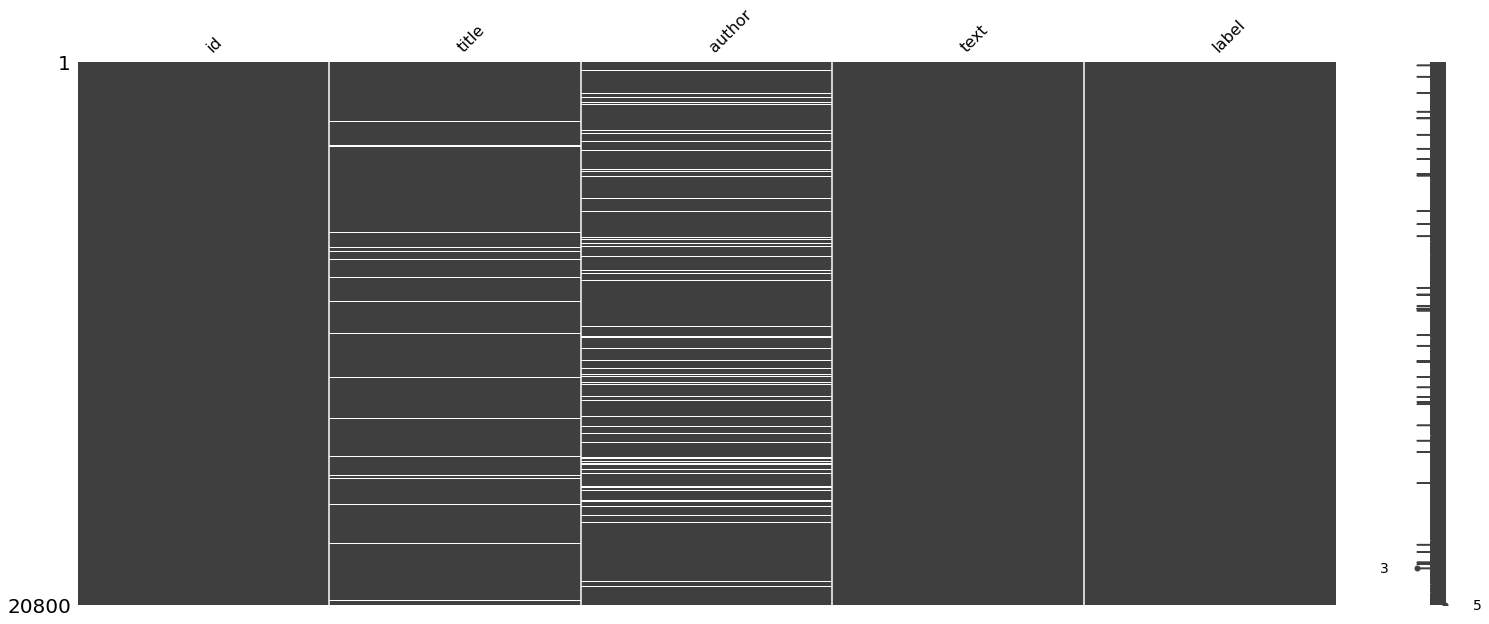

In [5]:
missingno.matrix(df_train)  #Checking missing values in dataframe

In [6]:
df_train.isnull().sum()  #no of missing values in dataframe

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [7]:
df_train.shape

(20800, 5)

In [8]:
df_train.fillna("", inplace=True)   #Missing values replaced with " "

<AxesSubplot:>

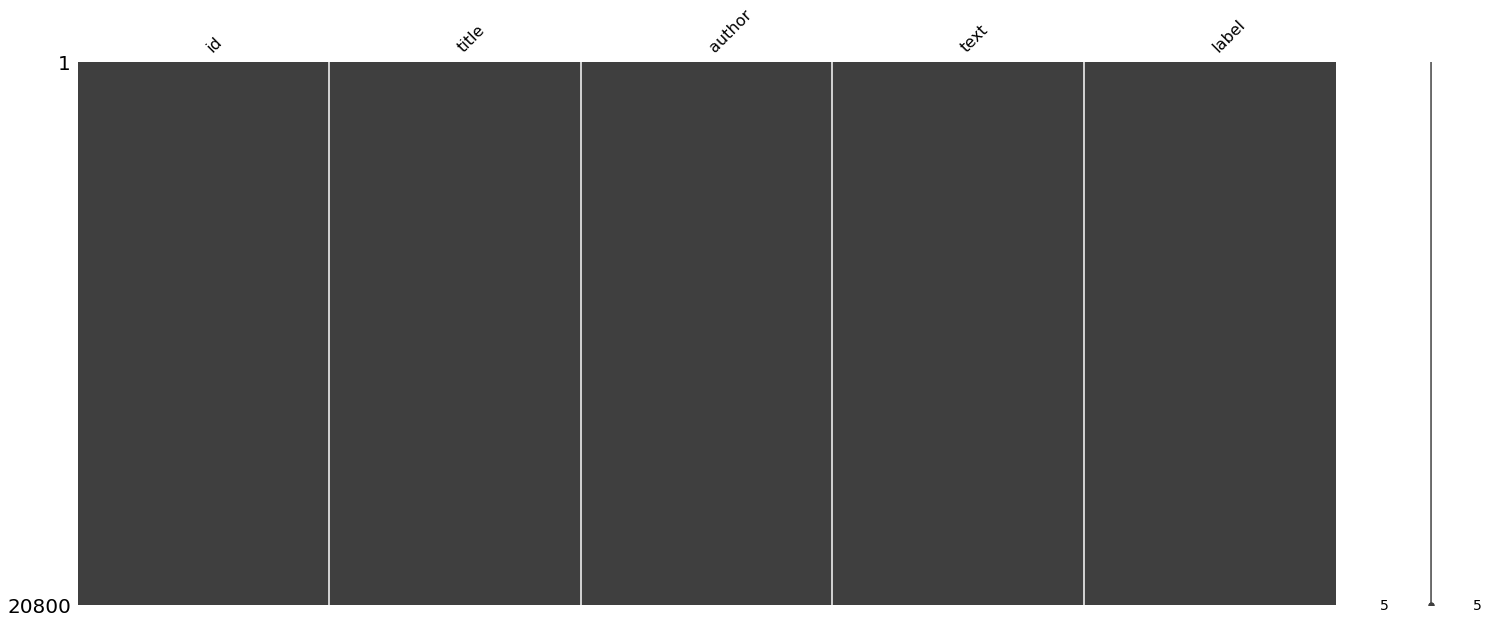

In [9]:
missingno.matrix(df_train)   #no missing values in training data

In [10]:
df_train.isnull().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [11]:
X=df_train.drop(labels=['label','id'],axis=1)

In [12]:
X.head()

,title,author,text
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ..."
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...


In [13]:
X.shape

(20800, 3)

<AxesSubplot:xlabel='count', ylabel='label'>

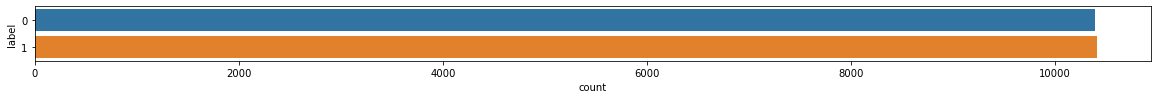

In [16]:
fig = plt.figure(figsize=(20,1))             #Equal no of positive and negative classes
sns.countplot(y="label", data=df_train)

In [17]:
y=df_train['label']

In [18]:
y.shape

(20800,)

In [19]:
vocab_size=5000

In [20]:
review=X.copy()

In [21]:
import nltk                          #nltk libraries for text preprocessing
import re
from nltk.corpus import stopwords

In [22]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ALIHAID\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
X['title'][0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It'

In [24]:
review['title'][1]

'FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart'

In [26]:
ps=PorterStemmer()
corpus=[]
for i in tqdm(range(0,len(review))):               #replacing characters other than alphabets with '' and performing stemming
    rev=re.sub('[^a-zA-z]',' ',X['title'][i])
    rev=rev.lower()
    rev=rev.split()
    rev=[ps.stem(word) for word in rev if word not in stopwords.words('english')]
    rev=' '.join(rev)
    corpus.append(rev)

100%|███████████████████████████████████████████████████████████████████████████| 20800/20800 [02:16<00:00, 152.51it/s]


In [27]:
corpus[0]  #Text data is cleaned

'hous dem aid even see comey letter jason chaffetz tweet'

In [28]:
corpus[1]

'flynn hillari clinton big woman campu breitbart'

In [29]:
one_hot_rep=[one_hot(word,vocab_size)for word in corpus]  #one hot endocing for word2vec

In [30]:
embed_matrix=pad_sequences(one_hot_rep,padding='pre',maxlen=20)  #Creating embedding matrix by adding padding sequence

In [31]:
embed_matrix

array([[   0,    0,    0, ..., 3948, 1075, 4456],
       [   0,    0,    0, ..., 4386, 1290, 1812],
       [   0,    0,    0, ..., 3307, 2094, 2074],
       ...,
       [   0,    0,    0, ..., 4651, 1464, 2986],
       [   0,    0,    0, ..., 4431,  905, 2336],
       [   0,    0,    0, ..., 4339, 1120, 2558]])

In [32]:
embedding_vector_feature=40
model=Sequential()
model.add(Embedding(vocab_size,embedding_vector_feature,input_length=20))
model.add(LSTM(100))                                 #modelling using lSTM
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 40)            200000    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               56400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________


In [33]:
X=np.array(embed_matrix)
y=np.array(y)            #Converting embed list to numpy array

In [34]:
X.shape

(20800, 20)

In [35]:
y.shape

(20800,)

In [36]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33,random_state=42) #Splitting data into train and test

In [37]:
X_train.shape

(13936, 20)

In [38]:
X_test.shape

(6864, 20)

In [39]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64) #Model Training

Epoch 1/10
218/218 [==============================] - 10s 33ms/step - loss: 0.4688 - accuracy: 0.7733 - val_loss: 0.1872 - val_accuracy: 0.9228
Epoch 2/10
218/218 [==============================] - 6s 29ms/step - loss: 0.1312 - accuracy: 0.9487 - val_loss: 0.1872 - val_accuracy: 0.9234
Epoch 3/10
218/218 [==============================] - 6s 29ms/step - loss: 0.0923 - accuracy: 0.9659 - val_loss: 0.2203 - val_accuracy: 0.9245
Epoch 4/10
218/218 [==============================] - 6s 28ms/step - loss: 0.0590 - accuracy: 0.9810 - val_loss: 0.2613 - val_accuracy: 0.9181
Epoch 5/10
218/218 [==============================] - 6s 27ms/step - loss: 0.0384 - accuracy: 0.9870 - val_loss: 0.3158 - val_accuracy: 0.9248
Epoch 6/10
218/218 [==============================] - 7s 30ms/step - loss: 0.0271 - accuracy: 0.9914 - val_loss: 0.3810 - val_accuracy: 0.9138
Epoch 7/10
218/218 [==============================] - 6s 29ms/step - loss: 0.0138 - accuracy: 0.9968 - val_loss: 0.3866 - val_accuracy: 0.920

In [40]:
y_pred=model.predict_classes(X_test) #Predicitng classes of test data

C:\Users\ALIHAID\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [41]:
confusion_matrix(y_test,y_pred)  #Confusion matrix

array([[3122,  327],
       [ 254, 3161]], dtype=int64)

In [42]:
accuracy_score(y_test,y_pred)   #accuracy score

0.9153554778554779

# Modelling using Dense and Dropout layers

In [77]:
embedding_vector_feature=40
model=Sequential()
model.add(Embedding(vocab_size,embedding_vector_feature,input_length=20))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(16,activation='relu'))
model.add(Dropout(0.2))                                   #Modelling using dense and droput layer with LSTM
model.add(Dense(16,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 20, 40)            200000    
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               56400     
_________________________________________________________________
dropout_11 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 16)                1616      
_________________________________________________________________
dropout_12 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                

In [78]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64) #Training my model

Epoch 1/10
218/218 [==============================] - 10s 31ms/step - loss: 0.4570 - accuracy: 0.7786 - val_loss: 0.1994 - val_accuracy: 0.9205
Epoch 2/10
218/218 [==============================] - 6s 29ms/step - loss: 0.1432 - accuracy: 0.9525 - val_loss: 0.1848 - val_accuracy: 0.9263
Epoch 3/10
218/218 [==============================] - 7s 31ms/step - loss: 0.0990 - accuracy: 0.9679 - val_loss: 0.2020 - val_accuracy: 0.9267
Epoch 4/10
218/218 [==============================] - 7s 31ms/step - loss: 0.0610 - accuracy: 0.9814 - val_loss: 0.2469 - val_accuracy: 0.9168
Epoch 5/10
218/218 [==============================] - 6s 29ms/step - loss: 0.0388 - accuracy: 0.9888 - val_loss: 0.2966 - val_accuracy: 0.9175
Epoch 6/10
218/218 [==============================] - 6s 28ms/step - loss: 0.0345 - accuracy: 0.9891 - val_loss: 0.3681 - val_accuracy: 0.9117
Epoch 7/10
218/218 [==============================] - 6s 28ms/step - loss: 0.0185 - accuracy: 0.9937 - val_loss: 0.3590 - val_accuracy: 0.915

In [79]:
y_pred=model.predict_classes(X_test)  #Predicitng classes on test data

In [80]:
confusion_matrix(y_test,y_pred)       #Confusion matrix

array([[3094,  355],
       [ 251, 3164]], dtype=int64)

In [81]:
accuracy_score(y_test,y_pred)     #accuracy on test data

0.9117132867132867